In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.dates import WeekdayLocator, DateFormatter, MonthLocator
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from  matplotlib.dates import WeekdayLocator, DateFormatter, MonthLocator
plt.style.use('fivethirtyeight')

In [2]:
from matplotlib.ticker import FuncFormatter

 - Настроить автоматическое скачивание датасета с GitHub
 - Переписать алгоритм с учетом внесенных изменений
 - Делать аннотацию на английском языке
  - сделать предсказание XGBRegressor
 - выложить файл на GitHub
  - выложить файл на Kaggle

## Introduction

Coronaviruses are a large family of viruses which may cause illness in animals or humans.  In humans, several coronaviruses are known to cause respiratory infections ranging from the common cold to more severe diseases such as Middle East Respiratory Syndrome (MERS) and Severe Acute Respiratory Syndrome (SARS). The most recently discovered coronavirus causes coronavirus disease COVID-19 [WHO](https://www.who.int/news-room/q-a-detail/q-a-coronaviruses).

**COVID-19** is the infectious disease caused by the most recently discovered coronavirus. This new virus and disease were unknown before the outbreak began in Wuhan, China, in December 2019. COVID-19 is now a pandemic affecting many countries globally.

I'll use **Data Repository by  Johns Hopkins CSSE** (https://github.com/CSSEGISandData/COVID-19). Three time series tables are for global confirmed cases, recovered cases and deaths:
* [`time_series_covid19_confirmed_global.csv`](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) 
* [`time_series_19-covid-Recovered.csv`](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv)
* [`time_series_19-covid-Deaths.csv`](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv)

In [3]:
path_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
path_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
path_recovered = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

Load time series tables into the dictionary `Covid`

In [284]:
data_files = {'Confirmed':path_confirmed,'Deaths':path_deaths, 'Recovered':path_recovered}
covid = {}
for key,value in data_files.items():
    covid[key] = pd.read_csv(value)

Reshape ever table for convenience

In [285]:
group_conf= covid['Confirmed'].groupby('Country/Region').sum()
group_conf = group_conf.reset_index()
confirmed_melt = group_conf.melt(id_vars=group_conf.columns[0], value_vars=group_conf.columns[3:])
confirmed_melt = confirmed_melt.rename(columns={'Country/Region':'Country','variable':'Date', 'value':'conf'})
confirmed_melt['Date'] = pd.to_datetime(confirmed_melt['Date'])
confirmed_melt['day_conf'] = confirmed_melt.groupby('Country')['conf'].diff()

In [286]:
confirmed_melt[confirmed_melt['Country']=='Russia']

Country       Date    conf  day_conf
140    Russia 2020-01-22       0       NaN
328    Russia 2020-01-23       0       0.0
516    Russia 2020-01-24       0       0.0
704    Russia 2020-01-25       0       0.0
892    Russia 2020-01-26       0       0.0
...       ...        ...     ...       ...
21572  Russia 2020-05-15  262843   10598.0
21760  Russia 2020-05-16  272043    9200.0
21948  Russia 2020-05-17  281752    9709.0
22136  Russia 2020-05-18  290678    8926.0
22324  Russia 2020-05-19  299941    9263.0

[119 rows x 4 columns]

In [287]:
group_death= covid['Deaths'].groupby('Country/Region').sum()
group_death = group_death.reset_index()
death_melt = group_death.melt(id_vars=group_death.columns[0], value_vars=group_death.columns[3:])
death_melt = death_melt.rename(columns={'Country/Region':'Country','variable':'Date', 'value':'death'})
death_melt['Date'] = pd.to_datetime(death_melt['Date'])
death_melt['day_death'] = death_melt.groupby('Country')['death'].diff()

In [288]:
death_melt[death_melt['Country']=='Russia']

Country       Date  death  day_death
140    Russia 2020-01-22      0        NaN
328    Russia 2020-01-23      0        0.0
516    Russia 2020-01-24      0        0.0
704    Russia 2020-01-25      0        0.0
892    Russia 2020-01-26      0        0.0
...       ...        ...    ...        ...
21572  Russia 2020-05-15   2418      113.0
21760  Russia 2020-05-16   2537      119.0
21948  Russia 2020-05-17   2631       94.0
22136  Russia 2020-05-18   2722       91.0
22324  Russia 2020-05-19   2837      115.0

[119 rows x 4 columns]

In [289]:
group_recover= covid['Recovered'].groupby('Country/Region').sum()
group_recover = group_recover.reset_index()
recovered_melt = group_recover.melt(id_vars=group_recover.columns[0], value_vars=group_recover.columns[3:])
recovered_melt = recovered_melt.rename(columns={'Country/Region':'Country','variable':'Date', 'value':'recover'})
recovered_melt['Date'] = pd.to_datetime(recovered_melt['Date'])
recovered_melt['day_recover'] = recovered_melt.groupby('Country')['recover'].diff()

In [290]:
recovered_melt[recovered_melt['Country']=='Russia']

Country       Date  recover  day_recover
140    Russia 2020-01-22        0          NaN
328    Russia 2020-01-23        0          0.0
516    Russia 2020-01-24        0          0.0
704    Russia 2020-01-25        0          0.0
892    Russia 2020-01-26        0          0.0
...       ...        ...      ...          ...
21572  Russia 2020-05-15    58226       4696.0
21760  Russia 2020-05-16    63166       4940.0
21948  Russia 2020-05-17    67373       4207.0
22136  Russia 2020-05-18    70209       2836.0
22324  Russia 2020-05-19    76130       5921.0

[119 rows x 4 columns]

In [291]:
all_data = pd.merge(confirmed_melt, recovered_melt)
all_data = pd.merge(all_data,death_melt)
all_data['day_ill'] = all_data['day_conf'] - all_data['day_recover'] - all_data['day_death']
all_data['ill'] = all_data['conf'] - all_data['recover'] - all_data['death']

All data is now in one table `all_data`.

In [292]:
all_data.head()

Country       Date  conf  day_conf  recover  day_recover  death  \
0  Afghanistan 2020-01-22     0       NaN        0          NaN      0   
1      Albania 2020-01-22     0       NaN        0          NaN      0   
2      Algeria 2020-01-22     0       NaN        0          NaN      0   
3      Andorra 2020-01-22     0       NaN        0          NaN      0   
4       Angola 2020-01-22     0       NaN        0          NaN      0   

   day_death  day_ill  ill  
0        NaN      NaN    0  
1        NaN      NaN    0  
2        NaN      NaN    0  
3        NaN      NaN    0  
4        NaN      NaN    0

Get the new table from `all_data` where the data will be grouped by country.

Now we'll calculate the growth for all/whole world `all_world`

In [244]:
all_world = all_data.groupby(['Date']).sum()
all_world = all_world[['day_ill','day_conf', 'day_recover', 'day_death']].copy()

In [245]:
def millions(x,pos):
    return '{:,}'.format(x).replace(',', ' ')

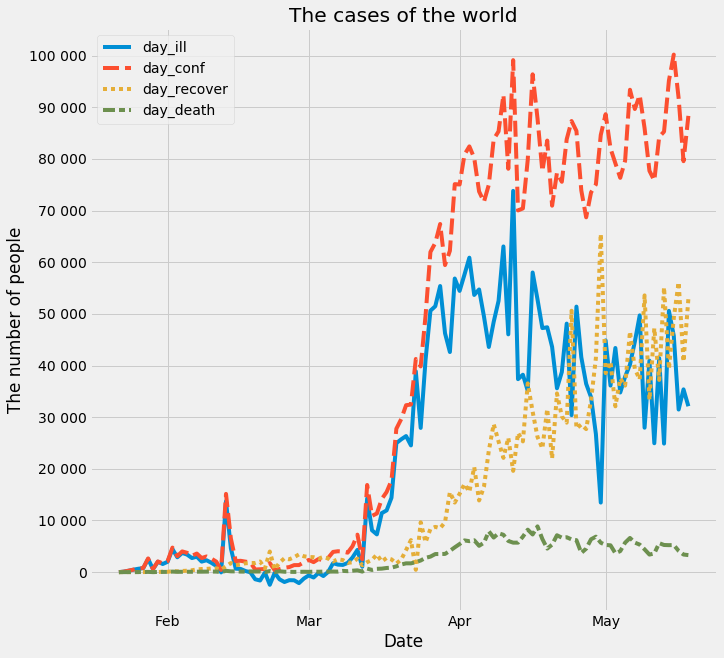

In [246]:
fig = plt.figure(figsize=(10,10))
m = sns.lineplot(data=all_world)
plt.ylabel('The number of people')
plt.title('The cases of the world')
plt.yticks(np.arange(0,105000,10000))
month_locator = MonthLocator(interval=1)
m.xaxis.set_major_locator(month_locator)
m.xaxis.set_major_formatter(DateFormatter('%b'))
formatter = FuncFormatter(millions)
m.yaxis.set_major_formatter(formatter)


In [247]:
all_data.groupby(['Date']).sum()

conf  day_conf  recover  day_recover   death  day_death  \
Date                                                                     
2020-01-22      555       0.0       28          0.0      17        0.0   
2020-01-23      654      99.0       30          2.0      18        1.0   
2020-01-24      941     287.0       36          6.0      26        8.0   
2020-01-25     1434     493.0       39          3.0      42       16.0   
2020-01-26     2118     684.0       52         13.0      56       14.0   
...             ...       ...      ...          ...     ...        ...   
2020-05-14  4442163   95145.0  1587893      39346.0  302418     5221.0   
2020-05-15  4542347  100184.0  1637067      49174.0  307666     5248.0   
2020-05-16  4634068   91721.0  1693197      56130.0  311781     4115.0   
2020-05-17  4713620   79552.0  1733963      40766.0  315185     3404.0   
2020-05-18  4801943   88323.0  1786875      52912.0  318481     3296.0   

            day_ill      ill  
Date                          
2020-01-22      0.0      510  
2020-01-23     96.0      606  
2020-01-24    273.0      879  
2020-01-25    474.0     1353  
2020-01-26    657.0     2010  
...             ...      ...  
2020-05-14  50578.0  2551852  
2020-05-15  45762.0  2597614  
2020-05-16  31476.0  2629090  
2020-05-17  35382.0  2664472  
2020-05-18  32115.0  2696587  

[118 rows x 8 columns]

Top countries with a hight level of confirmed cases Covid-19

In [248]:
top_10 = all_data.groupby('Country').max()
top_10 = top_10[['conf','death','recover']].copy()

In [249]:
top_10 = top_10.sort_values(by=['conf','death','recover'], ascending=False).head(5).copy()

In [250]:
top_10

conf  death  recover
Country                                
US              1508308  90347   283178
Russia           290678   2722    70209
Brazil           255368  16853   100459
United Kingdom   247709  34876     1090
Spain            231606  27709   150376

Text(0.5, 1.0, 'Countries with a hight level of confirmed cases of Covid-19')

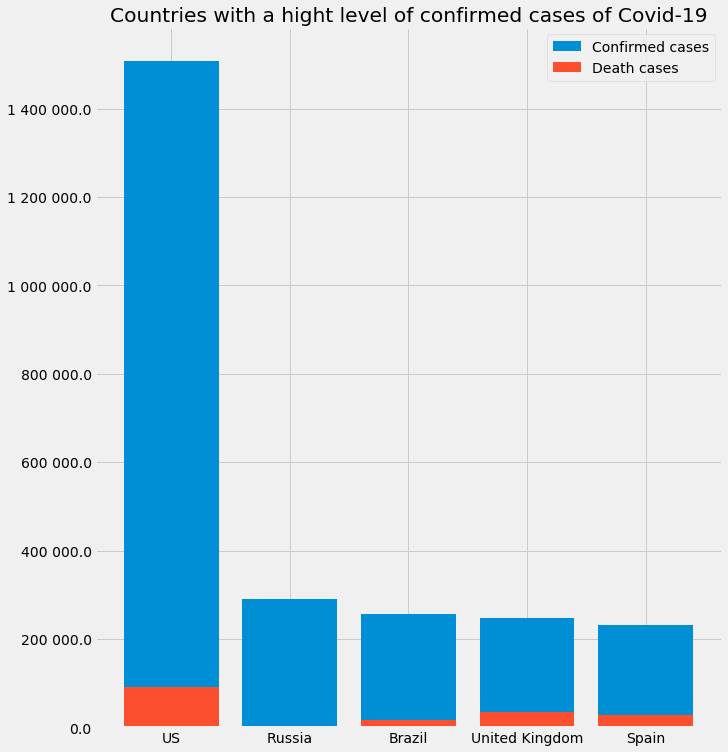

In [251]:
fig, ax = plt.subplots(figsize=(10,12))
ax.bar(top_10.index, top_10['conf'], label = 'Confirmed cases')
ax.bar(top_10.index, top_10['death'], label = 'Death cases')
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' ') )
ax.yaxis.set_major_formatter(formatter)
ax.legend()
plt.title('Countries with a hight level of confirmed cases of Covid-19')

Now we'll group by `Date`

In [161]:
data_russia = all_data[all_data['Country']=='Russia'].copy()

In [162]:
data_russia.fillna(0,inplace=True)

In [127]:
#data_russia['day_conf'].value_counts(normalize=True)
data_russia.describe()
print ('Дисперсия\n','{:2f}'.format(data_russia['day_conf'].var()))
print ('Среднее\n',data_russia['day_conf'].mean())
print ('Стандартное отклонение\n', data_russia['day_conf'].std())

Дисперсия
 13860651.221214
Среднее
 2345.198275862069
Стандартное отклонение
 3722.989554271459


In [213]:
print ('Frequency\n', data_russia['day_conf'].value_counts().head())

Frequency
 0.0      44
1.0       2
4.0       2
302.0     1
163.0     1
Name: day_conf, dtype: int64


In [214]:
print ('Probability\n', data_russia['day_conf'].value_counts(normalize=True).head())

Probability
 0.0      0.400000
1.0      0.018182
4.0      0.018182
302.0    0.009091
163.0    0.009091
Name: day_conf, dtype: float64


In [155]:
import math

In [157]:
# mu - мат.ожидание -> среднее mean
# sigma - стандартное отелонение
def normal_disribition(x, mu = 0, sigma =1):
    sqrt_two_pi = math.sqrt(2*math.pi)
    return (math.exp(-(x-mu) ** 2 / 2 / sigma ** 2)/(sqrt_two_pi * sigma))

In [252]:
data_russia = data_russia[data_russia['Date']> '2020-03-27'].sort_values(by='Date').copy()
index_date  = data_russia.copy()
index_date = index_date.set_index('Date')
index_date = index_date.drop(columns='Country')
mean_rolling = index_date.rolling(3).mean()
max_rolling = index_date.rolling(3).max()

In [253]:
#max_rolling = max_rolling.drop_duplicates('day_conf')
#data_russia['delta_diff'] = data_russia['day_conf'].diff(-1)
#extr_points = data_russia[data_russia['delta_diff']<0]

In [254]:
index_date['min'] = index_date['day_conf'][(index_date['day_conf'].shift(1) > index_date['day_conf']) & 
                               (index_date['day_conf'].shift(-1) > index_date['day_conf'])]


In [255]:
index_date['max'] = index_date['day_conf'][(index_date['day_conf'].shift(1) < index_date['day_conf']) & 
                               (index_date['day_conf'].shift(-1) < index_date['day_conf'])]

In [256]:
#largest_day = largest_day.drop(columns='Country').set_index('Date')

In [257]:
max_index = index_date['max'].dropna()

In [258]:
min_index = index_date['min'].dropna()

In [259]:
min_index

Date
2020-04-01      440.0
2020-04-04      582.0
2020-04-11     1667.0
2020-04-20     4268.0
2020-04-23     4774.0
2020-04-27     6198.0
2020-04-29     5841.0
2020-05-05    10102.0
2020-05-08    10699.0
2020-05-14     9974.0
2020-05-16     9200.0
Name: min, dtype: float64

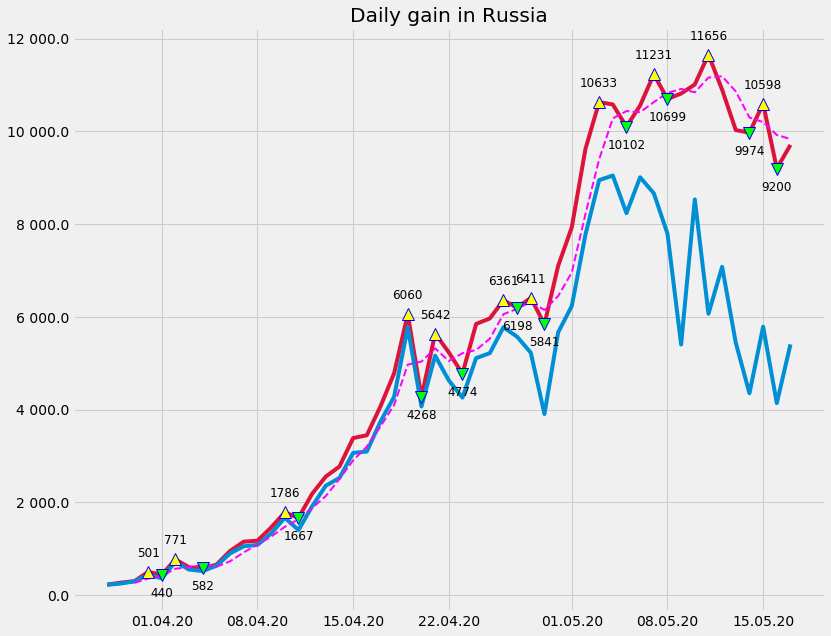

In [260]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(data_russia['Date'], data_russia['day_conf'], color='crimson')
ax.plot(data_russia['Date'],data_russia['day_ill'])
ax.plot(mean_rolling.index,mean_rolling['day_conf'],  color='magenta', linestyle='--', linewidth=2)

ax.plot(index_date.index, index_date['min'],linestyle=' ', marker='v', color='lime', markersize=12, markeredgecolor='blue')
ax.plot(index_date.index, index_date['max'],linestyle=' ', marker='^', color='yellow', markersize=12, markeredgecolor='blue')

formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
#month_locator = MonthLocator(interval=1)
#ax.xaxis.set_major_locator(DateFormatter(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
#ax.axvline(max_point['Date'], linestyle='--', linewidth=1.5, color='green')

ax.set_title('Daily gain in Russia')

# !!!ax.vlines(index_date.index, [0], index_date['max'],  linestyle='--', linewidth=1, color='green', label='1')
#for index,row in max_index.iterrows():
for index,value in max_index.iteritems():
    #ax.text(index,row['max']+300, '{:n}'.format(row['max']), 
    ax.text(index,value+400, '{:n}'.format(value), 
            horizontalalignment='center',verticalalignment='center', fontsize=12)
for index,value in min_index.iteritems():
    #ax.text(index,row['max']+300, '{:n}'.format(row['max']), 
    ax.text(index,value-400, '{:n}'.format(value), 
            horizontalalignment='center',verticalalignment='center', fontsize=12)
        
    

Text(0, 0.5, 'Number of cases')

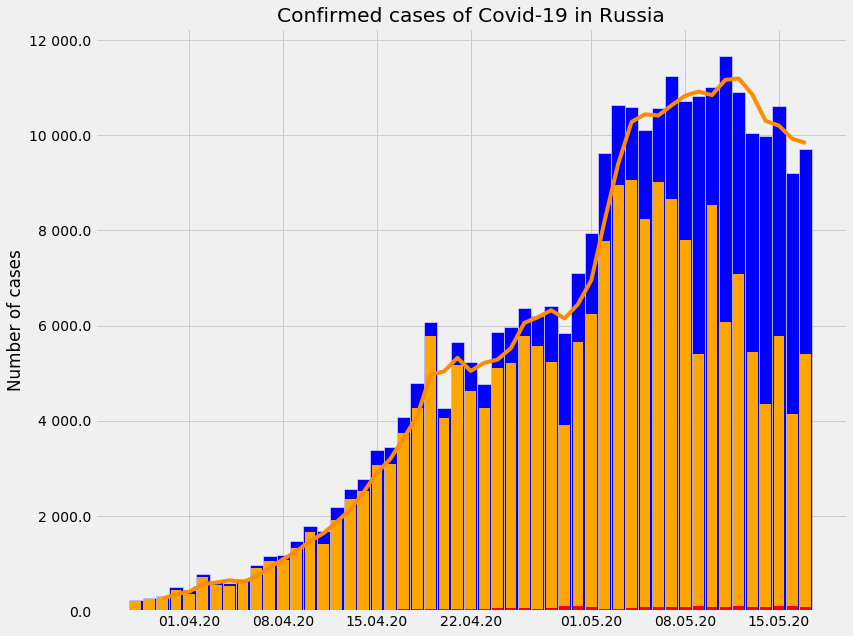

In [261]:
fig, ax = plt.subplots(figsize=(12,10))
x = np.arange(1, len(data_russia)+1)
ax.bar(data_russia['Date'],data_russia['day_conf'], color='blue', width=1,
        bottom =10, align='center', edgecolor='white')
ax.bar(data_russia['Date'], data_russia['day_ill'], color = 'orange')
ax.bar(data_russia['Date'], data_russia['day_death'], color = 'red')
ax.plot(mean_rolling.index,mean_rolling['day_conf'],  color='darkorange', linestyle='-', linewidth=4)
month_locator = MonthLocator(interval=1)
#ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_title('Confirmed cases of Covid-19 in Russia')
ax.set_ylabel('Number of cases')


In [262]:
russia_day = data_russia[['Date', 'day_conf', 'day_recover', 'day_death']].copy()

In [263]:
russia_day = russia_day.set_index('Date')

In [264]:
russia_day['day_conf'].iloc[-1]

9709.0

Text(0.5, 0, '')

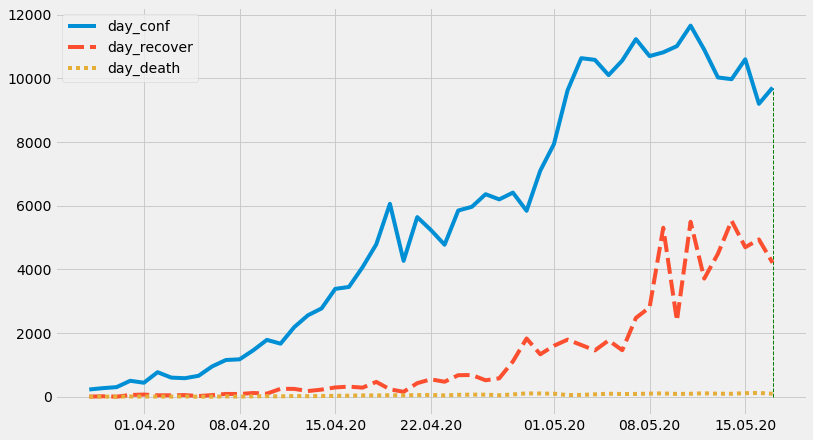

In [265]:
fig, ax = plt.subplots(figsize=(12,7))
m = sns.lineplot(data = russia_day)
month_locator = MonthLocator(interval=1)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))

ax.vlines(russia_day.index[-1], [0], russia_day['day_conf'].iloc[-1],
          linestyle='--', linewidth=1, color='green', label='1')
ax.set_xlabel('')

In [266]:
months = data_russia['Date'].dt.month_name().unique()

In [39]:
data_russia.describe()

conf      day_conf       recover  day_recover        death  \
count      51.000000     51.000000     51.000000    51.000000    51.000000   
mean    88515.117647   5504.235294  13543.529412  1320.156863   813.607843   
std     88509.627961   3952.178668  18511.832130  1691.546291   823.546722   
min      1264.000000    228.000000     49.000000     2.000000     4.000000   
25%     11024.000000   1563.000000    746.500000   107.500000    85.000000   
50%     57999.000000   5642.000000   4420.000000   471.000000   513.000000   
75%    150319.000000   9841.500000  18980.000000  1781.500000  1403.500000   
max    281752.000000  11656.000000  67373.000000  5527.000000  2631.000000   

        day_death  
count   51.000000  
mean    51.509804  
std     38.126827  
min      0.000000  
25%     12.500000  
50%     48.000000  
75%     90.500000  
max    119.000000

In [36]:
data_russia.median()

conf           32008.0
day_conf        4070.0
recover         2590.0
day_recover      286.0
death            273.0
day_death         40.0
dtype: float64

### Decision Tree

In [40]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

В качестве признаков импользуем даты (что сомнительно, т.к это временной ряд)

In [232]:
data_russia = all_data[(all_data['Country']=='Russia') & (all_data['Date']>'2020-02-29')].copy()
data_russia['Day'] = data_russia['Date'].dt.day
data_russia['Month'] = data_russia['Date'].dt.month
data_russia['Dayofweek'] = data_russia['Date'].dt.dayofweek
X = data_russia[['Day','Month','Dayofweek']]
Y = data_russia['day_conf']
Y.fillna(0,inplace=True)
X = X.values
#X = np.arange(len(Y))
#X = X.reshape(-1,1)
Y = Y.values
X_train, X_test, y_train, y_test = train_test_split(X, Y)

В качестве признаков возьмем:
    - количество болеющих в день day_ill;
    - количество выздоревших в день day_recover;
    - количество умерших в день day_death.
Целевой **вектор Y** - количество подтвержденных случаев заболевания в день day_conf

In [177]:
data_russia[['conf','ill','recover','death']].corr()

conf       ill   recover     death
conf     1.000000  0.997231  0.959397  0.999337
ill      0.997231  1.000000  0.935764  0.997176
recover  0.959397  0.935764  1.000000  0.956404
death    0.999337  0.997176  0.956404  1.000000

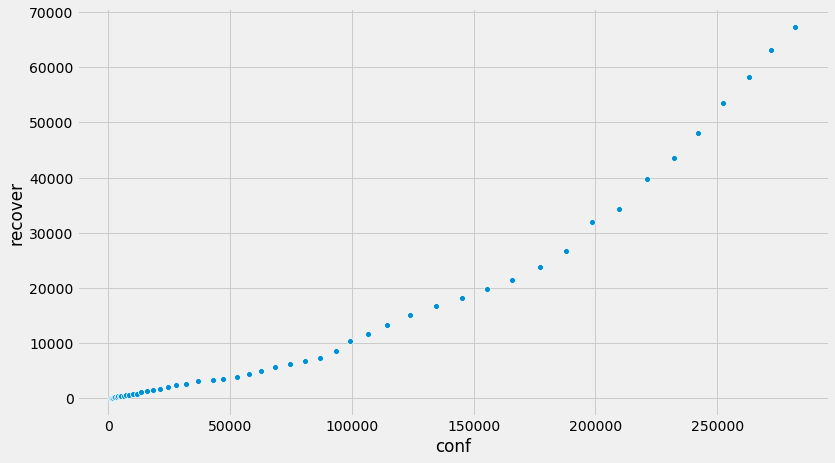

In [181]:
fig, ax = plt.subplots(figsize=(12,7))
sns.scatterplot(x='conf',y='recover',data=data_russia)

In [268]:
data_russia

Country       Date    conf  day_conf  recover  day_recover  death  \
12548  Russia 2020-03-28    1264     228.0       49          4.0      4   
12736  Russia 2020-03-29    1534     270.0       64         15.0      8   
12924  Russia 2020-03-30    1836     302.0       66          2.0      9   
13112  Russia 2020-03-31    2337     501.0      121         55.0     17   
13300  Russia 2020-04-01    2777     440.0      190         69.0     24   
13488  Russia 2020-04-02    3548     771.0      235         45.0     30   
13676  Russia 2020-04-03    4149     601.0      281         46.0     34   
13864  Russia 2020-04-04    4731     582.0      333         52.0     43   
14052  Russia 2020-04-05    5389     658.0      355         22.0     45   
14240  Russia 2020-04-06    6343     954.0      406         51.0     47   
14428  Russia 2020-04-07    7497    1154.0      494         88.0     58   
14616  Russia 2020-04-08    8672    1175.0      580         86.0     63   
14804  Russia 2020-04-09   10131    1459.0      698        118.0     76   
14992  Russia 2020-04-10   11917    1786.0      795         97.0     94   
15180  Russia 2020-04-11   13584    1667.0     1045        250.0    106   
15368  Russia 2020-04-12   15770    2186.0     1291        246.0    130   
15556  Russia 2020-04-13   18328    2558.0     1470        179.0    148   
15744  Russia 2020-04-14   21102    2774.0     1694        224.0    170   
15932  Russia 2020-04-15   24490    3388.0     1986        292.0    198   
16120  Russia 2020-04-16   27938    3448.0     2304        318.0    232   
16308  Russia 2020-04-17   32008    4070.0     2590        286.0    273   
16496  Russia 2020-04-18   36793    4785.0     3057        467.0    313   
16684  Russia 2020-04-19   42853    6060.0     3291        234.0    361   
16872  Russia 2020-04-20   47121    4268.0     3446        155.0    405   
17060  Russia 2020-04-21   52763    5642.0     3873        427.0    456   
17248  Russia 2020-04-22   57999    5236.0     4420        547.0    513   
17436  Russia 2020-04-23   62773    4774.0     4891        471.0    555   
17624  Russia 2020-04-24   68622    5849.0     5568        677.0    615   
17812  Russia 2020-04-25   74588    5966.0     6250        682.0    681   
18000  Russia 2020-04-26   80949    6361.0     6767        517.0    747   
18188  Russia 2020-04-27   87147    6198.0     7346        579.0    794   
18376  Russia 2020-04-28   93558    6411.0     8456       1110.0    867   
18564  Russia 2020-04-29   99399    5841.0    10286       1830.0    972   
18752  Russia 2020-04-30  106498    7099.0    11619       1333.0   1073   
18940  Russia 2020-05-01  114431    7933.0    13220       1601.0   1169   
19128  Russia 2020-05-02  124054    9623.0    15013       1793.0   1222   
19316  Russia 2020-05-03  134687   10633.0    16639       1626.0   1280   
19504  Russia 2020-05-04  145268   10581.0    18095       1456.0   1356   
19692  Russia 2020-05-05  155370   10102.0    19865       1770.0   1451   
19880  Russia 2020-05-06  165929   10559.0    21327       1462.0   1537   
20068  Russia 2020-05-07  177160   11231.0    23803       2476.0   1625   
20256  Russia 2020-05-08  187859   10699.0    26608       2805.0   1723   
20444  Russia 2020-05-09  198676   10817.0    31916       5308.0   1827   
20632  Russia 2020-05-10  209688   11012.0    34306       2390.0   1915   
20820  Russia 2020-05-11  221344   11656.0    39801       5495.0   2009   
21008  Russia 2020-05-12  232243   10899.0    43512       3711.0   2116   
21196  Russia 2020-05-13  242271   10028.0    48003       4491.0   2212   
21384  Russia 2020-05-14  252245    9974.0    53530       5527.0   2305   
21572  Russia 2020-05-15  262843   10598.0    58226       4696.0   2418   
21760  Russia 2020-05-16  272043    9200.0    63166       4940.0   2537   
21948  Russia 2020-05-17  281752    9709.0    67373       4207.0   2631   

       day_death  day_ill     ill  Day  Month  Dayofweek  
12548        0.0    224.0    1211   28      3 

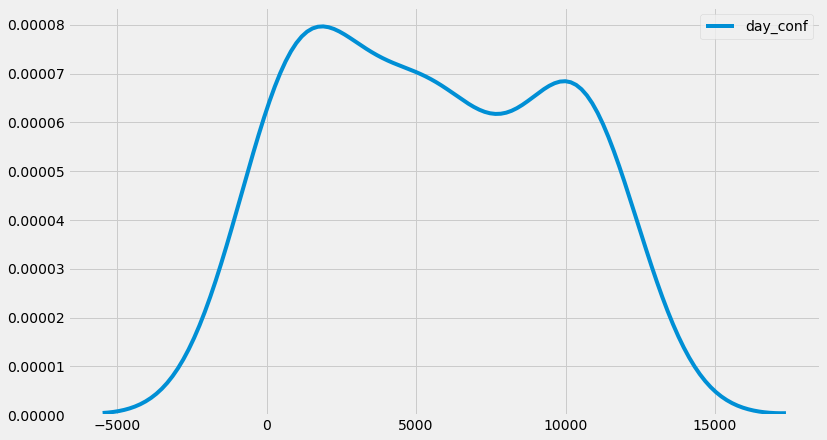

In [279]:
fig, ax = plt.subplots(figsize=(12,7))
#ax.hist(data_russia['conf'], bins=15, density=True, histtype='bar')
#ax.plot(data_russia['conf'],data_russia['day_conf'])
#sns.kdeplot(data_russia['conf'])
sns.kdeplot(data_russia['day_conf'])

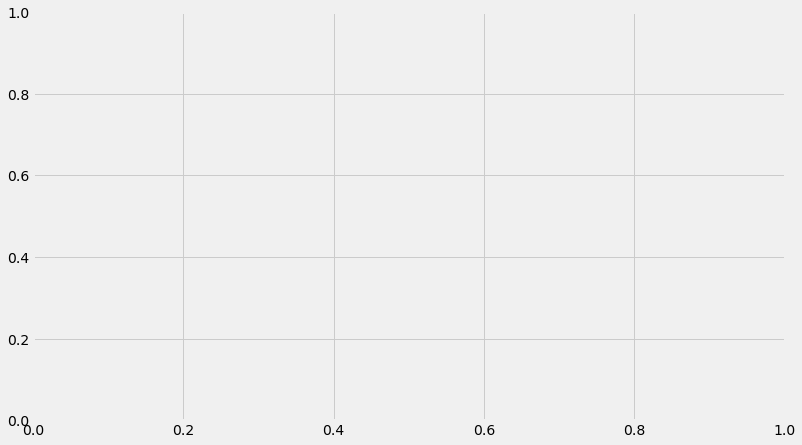

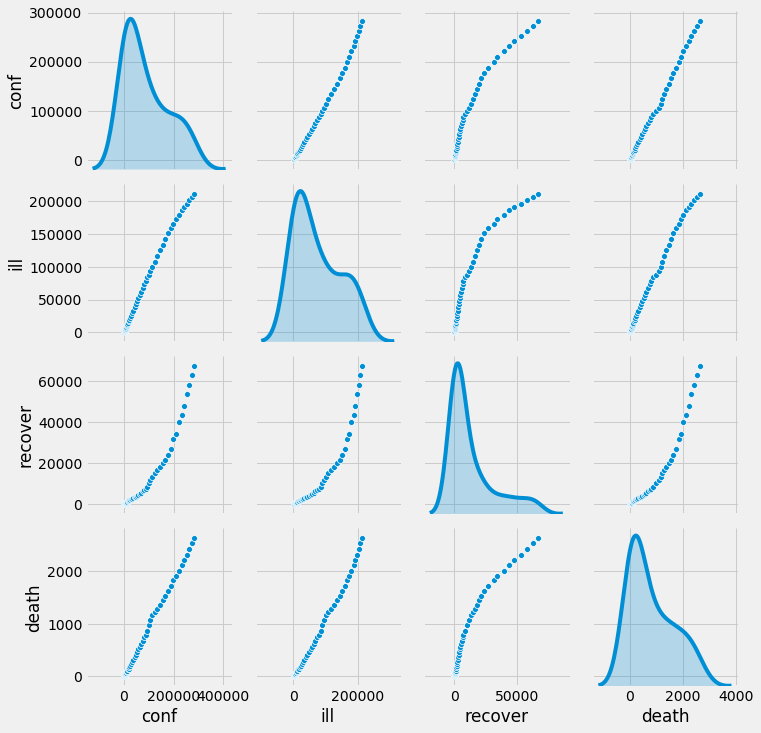

In [184]:
fig, ax = plt.subplots(figsize=(12,7))
sns.pairplot(data=data_russia[['conf','ill','recover','death']], kind ='scatter',diag_kind='kde')

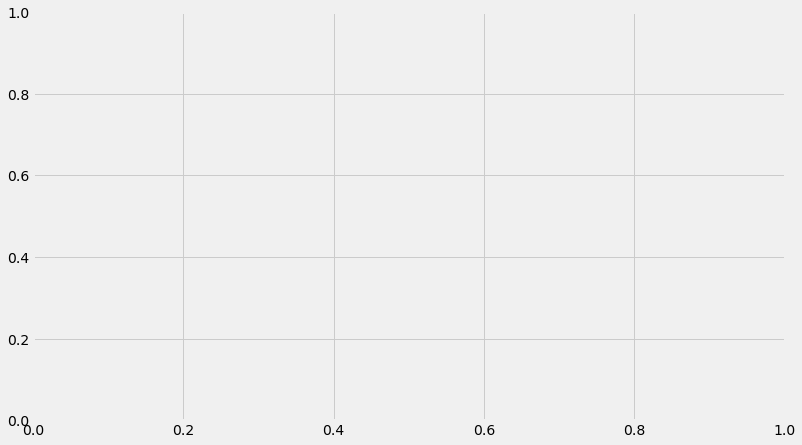

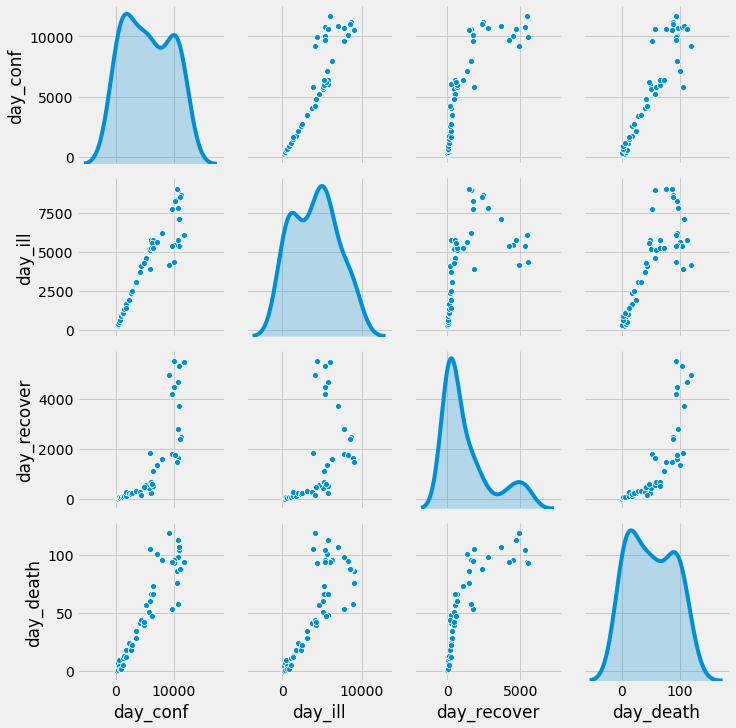

In [185]:
fig, ax = plt.subplots(figsize=(12,7))
sns.pairplot(data=data_russia[['day_conf','day_ill','day_recover','day_death']], kind ='scatter',diag_kind='kde')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B2F25555C8>,
      dtype=object)

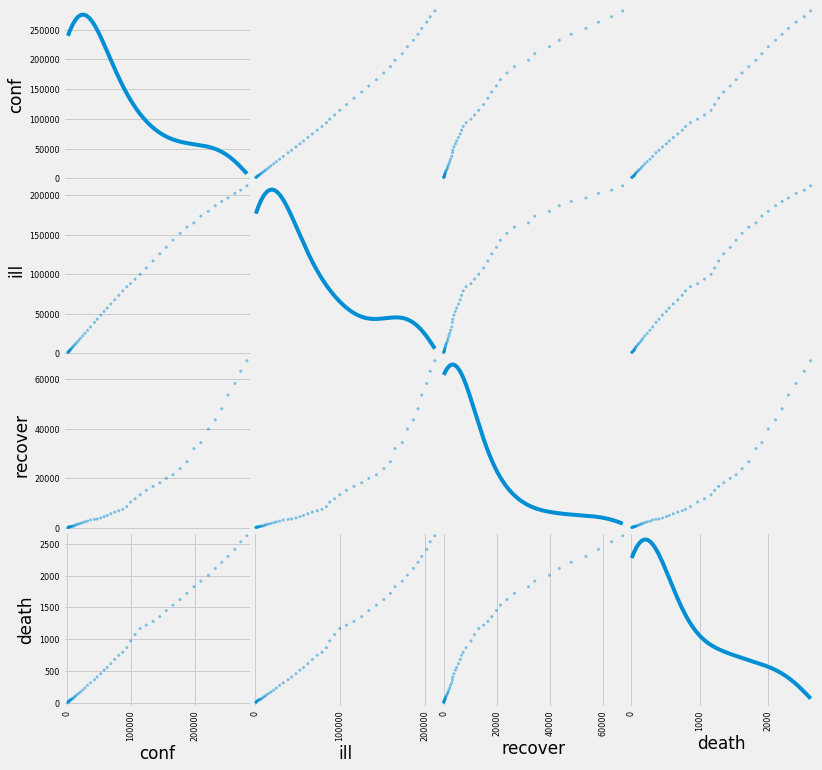

In [189]:
from pandas.plotting import scatter_matrix
scatter_matrix(data_russia[['conf','ill','recover','death']], diagonal='kde', figsize=(12,12))

(array([20.,  5.,  5.,  4.,  3.,  3.,  2.,  3.,  3.,  3.]),
 array([  1264. ,  29312.8,  57361.6,  85410.4, 113459.2, 141508. ,
        169556.8, 197605.6, 225654.4, 253703.2, 281752. ]),
 <a list of 10 Patch objects>)

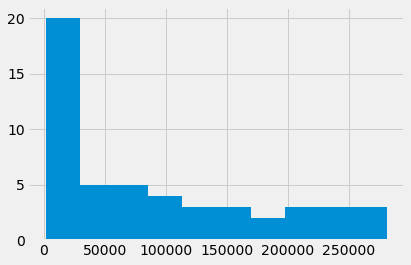

In [186]:
plt.hist(data_russia['conf'])

In [196]:
from sklearn import preprocessing

In [219]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
X = data_russia[['ill','recover','death']].copy()
#X = data_russia['ill'].copy()
Y = data_russia['conf']
X = X.values
#X = X.reshape(-1,1)
Y = Y.values
scaled_feature = minmax_scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_feature, Y)

In [215]:
from sklearn.linear_model import LinearRegression

In [233]:
regression = LinearRegression()
model_reg = regression.fit(X_train, y_train)
reg_prediction = model_reg.predict(X_test)
print(mean_absolute_error(y_test, reg_prediction))

867.8753979992932


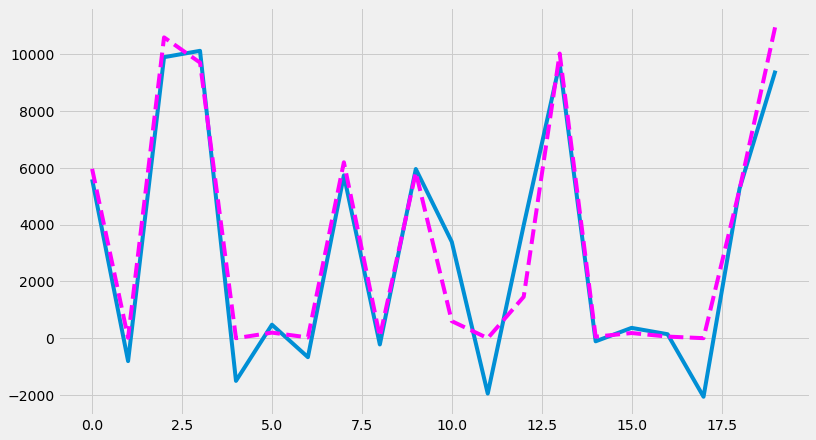

In [234]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(reg_prediction)
ax.plot(y_test,color='magenta', linestyle='--')
#ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
#formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
#ax.yaxis.set_major_formatter(formatter)
#ax.set_xlabel('')
#ax.legend()

In [209]:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    preds_val = model.predict(val_X)
    mae = mean_absolute_error(val_y, preds_val)
    return(mae)

In [210]:
for max_leaf_nodes in [2,3,4,5,6,7,8,9,10,12,13,14,15]:
    my_mae = get_mae(max_leaf_nodes, X_train, X_test, y_train, y_test)
    print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(max_leaf_nodes, my_mae))

Max leaf nodes: 2  		 Mean Absolute Error:  38101
Max leaf nodes: 3  		 Mean Absolute Error:  31865
Max leaf nodes: 4  		 Mean Absolute Error:  19011
Max leaf nodes: 5  		 Mean Absolute Error:  15285
Max leaf nodes: 6  		 Mean Absolute Error:  12704
Max leaf nodes: 7  		 Mean Absolute Error:  12225
Max leaf nodes: 8  		 Mean Absolute Error:  12225
Max leaf nodes: 9  		 Mean Absolute Error:  10067
Max leaf nodes: 10  		 Mean Absolute Error:  9441
Max leaf nodes: 12  		 Mean Absolute Error:  7924
Max leaf nodes: 13  		 Mean Absolute Error:  7503
Max leaf nodes: 14  		 Mean Absolute Error:  7464
Max leaf nodes: 15  		 Mean Absolute Error:  7464


In [211]:
covid_model = DecisionTreeRegressor()
covid_model.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [212]:
val_predictions = covid_model.predict(X_test)
print(mean_absolute_error(y_test, val_predictions))

5238.153846153846


This was done to merge columns into one 'Date' value

In [77]:
x_test = pd.DataFrame(X_test[:,0:2], columns=['Day', 'Month'])
x_test['year'] = '2020'
x_test['all'] = pd.to_datetime(x_test)
x_test['Test'] = y_test
x_test['Decision_tree'] = val_predictions

ValueError: Shape of passed values is (20, 1), indices imply (20, 2)

In [50]:
x_test.drop(columns=['Day','Month','year'],inplace=True)

In [51]:
#x_test = x_test.sort_values(by='all').set_index('all')
x_test = x_test.set_index('all')

In [52]:
x_test

Test  Decision_tree
all                               
2020-04-08   1175.0     903.000000
2020-04-30   7099.0    6104.333333
2020-05-16   9200.0   10093.666667
2020-03-14     14.0      60.640000
2020-04-19   6060.0    5067.000000
2020-05-11  11656.0   10744.000000
2020-03-19     52.0      60.640000
2020-03-28    228.0      60.640000
2020-04-02    771.0     903.000000
2020-04-05    658.0     903.000000
2020-04-22   5236.0    5067.000000
2020-04-01    440.0     903.000000
2020-05-04  10581.0   10744.000000
2020-05-13  10028.0   10744.000000
2020-04-17   4070.0    3418.000000
2020-03-31    501.0      60.640000
2020-04-04    582.0     903.000000
2020-04-09   1459.0    1726.500000
2020-03-04      0.0      60.640000
2020-03-17     24.0      60.640000

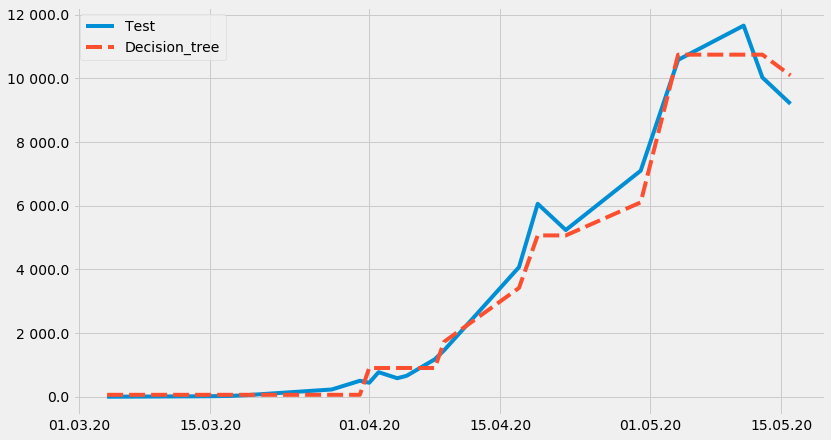

In [53]:
fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(data = x_test)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('')
ax.legend()

### Random Forest

In [129]:
from sklearn.ensemble import RandomForestRegressor

In [130]:
forest_model = RandomForestRegressor(n_estimators=1000, random_state=0)

In [205]:
forest_model.fit(X_train, y_train)
preds = forest_model.predict(X_test)
# Evaluate the model
score = mean_absolute_error(y_test, preds)
print('MAE:', score)

MAE: 2925.227769230773


In [132]:
x_test['Random_forest'] = preds

ValueError: Length of values does not match length of index

In [58]:
x_test

Test  Decision_tree  Random_forest
all                                              
2020-04-08   1175.0     903.000000       1250.678
2020-04-30   7099.0    6104.333333       5976.518
2020-05-16   9200.0   10093.666667      10361.748
2020-03-14     14.0      60.640000         13.102
2020-04-19   6060.0    5067.000000       4734.019
2020-05-11  11656.0   10744.000000      10792.782
2020-03-19     52.0      60.640000         39.938
2020-03-28    228.0      60.640000        218.340
2020-04-02    771.0     903.000000        970.745
2020-04-05    658.0     903.000000       1052.928
2020-04-22   5236.0    5067.000000       5352.829
2020-04-01    440.0     903.000000       1020.188
2020-05-04  10581.0   10744.000000      10219.283
2020-05-13  10028.0   10744.000000      10630.270
2020-04-17   4070.0    3418.000000       3696.468
2020-03-31    501.0      60.640000        272.238
2020-04-04    582.0     903.000000        941.302
2020-04-09   1459.0    1726.500000       1627.862
2020-03-04      0.0      60.640000          0.604
2020-03-17     24.0      60.640000         27.357

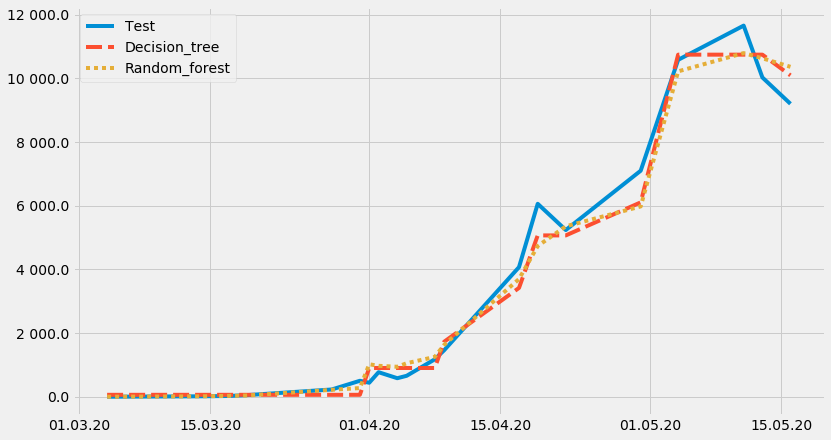

In [59]:
fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(data = x_test)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('')
ax.legend()

### Gradient boosting

In [206]:
russia_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
russia_model.fit(X_train, y_train, verbose=False)
predictions = russia_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

[22:53:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Absolute Error: 6637.64990234375


In [134]:
x_test['XGBRegressor'] = predictions

ValueError: Length of values does not match length of index

In [62]:
x_test

Test  Decision_tree  Random_forest  XGBRegressor
all                                                            
2020-04-08   1175.0     903.000000       1250.678   1269.757446
2020-04-30   7099.0    6104.333333       5976.518   5964.987305
2020-05-16   9200.0   10093.666667      10361.748   9675.789062
2020-03-14     14.0      60.640000         13.102     83.248398
2020-04-19   6060.0    5067.000000       4734.019   4425.316895
2020-05-11  11656.0   10744.000000      10792.782  10717.729492
2020-03-19     52.0      60.640000         39.938    119.670265
2020-03-28    228.0      60.640000        218.340    272.745056
2020-04-02    771.0     903.000000        970.745   1056.677979
2020-04-05    658.0     903.000000       1052.928   1071.542114
2020-04-22   5236.0    5067.000000       5352.829   5049.113281
2020-04-01    440.0     903.000000       1020.188   1056.677979
2020-05-04  10581.0   10744.000000      10219.283  10157.488281
2020-05-13  10028.0   10744.000000      10630.270  10202.100586
2020-04-17   4070.0    3418.000000       3696.468   4421.750000
2020-03-31    501.0      60.640000        272.238    247.659073
2020-04-04    582.0     903.000000        941.302   1071.542114
2020-04-09   1459.0    1726.500000       1627.862   1697.092651
2020-03-04      0.0      60.640000          0.604    -49.875751
2020-03-17     24.0      60.640000         27.357    100.633781

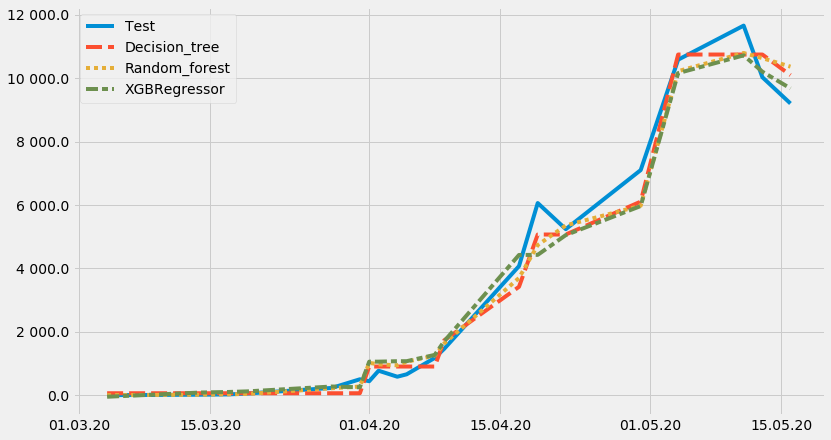

In [63]:
fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(data = x_test)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('')
ax.legend()

Will do forecast with 16/05/2020 to 31/05/2020

In [163]:
forecast_x =  pd.date_range(start = '2020-05-16', end = '2020-05-31', freq='D')

In [164]:
day = forecast_x.day.values
month = forecast_x.month.values
week = forecast_x.dayofweek.values
day = day.reshape(-1,1)
month = month.reshape(-1,1)
week = week.reshape(-1,1)

In [165]:
array_forecast = np.concatenate((day,month,week), axis =1)

In [166]:
array_forecast

array([[16,  5,  5],
       [17,  5,  6],
       [18,  5,  0],
       [19,  5,  1],
       [20,  5,  2],
       [21,  5,  3],
       [22,  5,  4],
       [23,  5,  5],
       [24,  5,  6],
       [25,  5,  0],
       [26,  5,  1],
       [27,  5,  2],
       [28,  5,  3],
       [29,  5,  4],
       [30,  5,  5],
       [31,  5,  6]], dtype=int64)

In [86]:
array_forecast = np.arange(78,88)
array_forecast = array_forecast.reshape(-1,1)

In [87]:
array_forecast

array([[78],
       [79],
       [80],
       [81],
       [82],
       [83],
       [84],
       [85],
       [86],
       [87]])

In [88]:
#decision tree
decision_tree = covid_model.predict(array_forecast)
decision_tree = decision_tree.reshape(-1,1)

#random forest
random_forest = forest_model.predict(array_forecast)
random_forest = random_forest.reshape(-1,1)

#gradient boosting
grad_boosting = russia_model.predict(array_forecast)
grad_boosting = grad_boosting.reshape(-1,1)

In [89]:
prediction = np.concatenate((decision_tree,random_forest, grad_boosting),axis=1)
#random_forest

In [90]:
prediction

array([[9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094],
       [9454.5       , 9691.826     , 9465.67871094]])

NameError: name 'forecast_x' is not defined

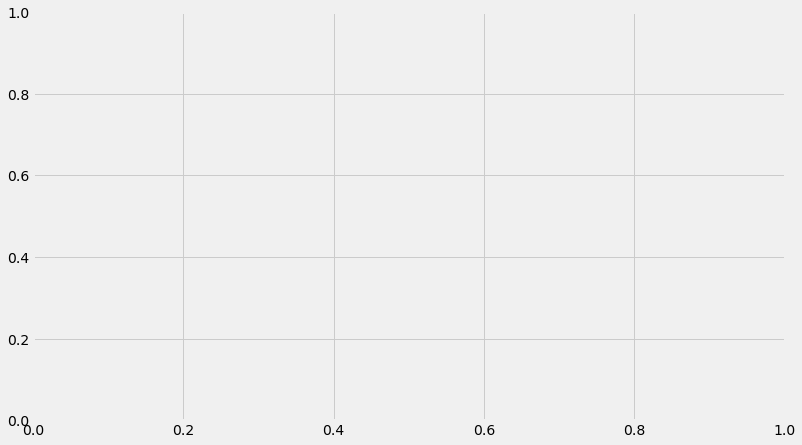

In [91]:
fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(x=forecast_x, y = prediction[:,0])
sns.lineplot(x=forecast_x, y = prediction[:,1])
sns.lineplot(x=forecast_x, y = prediction[:,2])
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('')
ax.legend()

In [38]:
data_russia.iloc[:,2:].var()

conf           2.793124e+09
day_conf       1.177203e+07
recover        4.480787e+07
day_recover    4.397466e+05
death          2.552436e+05
day_death      1.045755e+03
dtype: float64

In [580]:
data_russia.iloc[:,2:].std()

conf           40301.747457
day_conf        3014.675264
recover         4470.063966
day_recover      495.747285
death            386.457453
day_death         29.433752
dtype: float64

In [584]:
data_russia.iloc[:,2:].corr()

conf  day_conf   recover  day_recover     death  day_death
conf         1.000000  0.973196  0.981205     0.947474  0.998280   0.922157
day_conf     0.973196  1.000000  0.940302     0.894926  0.962676   0.911727
recover      0.981205  0.940302  1.000000     0.960514  0.986506   0.861094
day_recover  0.947474  0.894926  0.960514     1.000000  0.958504   0.886919
death        0.998280  0.962676  0.986506     0.958504  1.000000   0.918821
day_death    0.922157  0.911727  0.861094     0.886919  0.918821   1.000000

In [541]:
data_days.tail()

conf  recover   death
Date                                
2020-04-27  3023722   873677  214484
2020-04-28  3097190   906943  220799
2020-04-29  3172287   948425  227665
2020-04-30  3256853  1013871  233357
2020-05-01  3343777  1052415  238619

In [171]:
all_country_last_day=all_data[all_data["Date"]==all_data["Date"].max()].groupby(["Country"]).agg({"conf":'sum',"recover":'sum',"death":'sum'}).sort_values(["conf"],ascending=False)

In [172]:
all_country_last_day

conf  recover  death
Country                                  
US                1467820   268376  88754
Russia             272043    63166   2537
United Kingdom     241461     1058  34546
Brazil             233511    89672  15662
Spain              230698   146446  27563
...                   ...      ...    ...
Suriname               10        9      1
MS Zaandam              9        0      2
Papua New Guinea        8        8      0
Western Sahara          6        6      0
Lesotho                 1        0      0

[188 rows x 3 columns]

Text(0.5, 0, '')

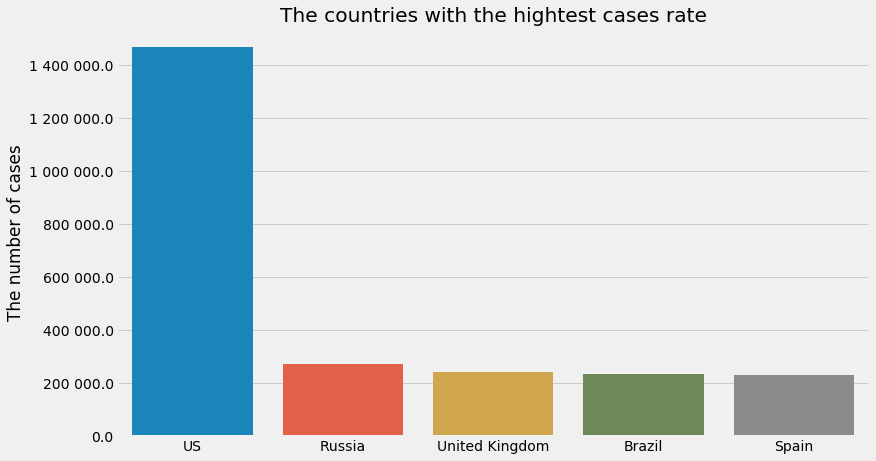

In [174]:
fig, ax = plt.subplots(figsize=(12,7))
sns.barplot(x = all_country_last_day.index[0:5], y = all_country_last_day.iloc[0:5,0])
#sns.barplot(x = all_country_last_day.index[0:5], y = all_country_last_day.iloc[0:5,1])
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)
ax.set_title('The countries with the hightest cases rate')
ax.set_ylabel('The number of cases')
ax.set_xlabel('')

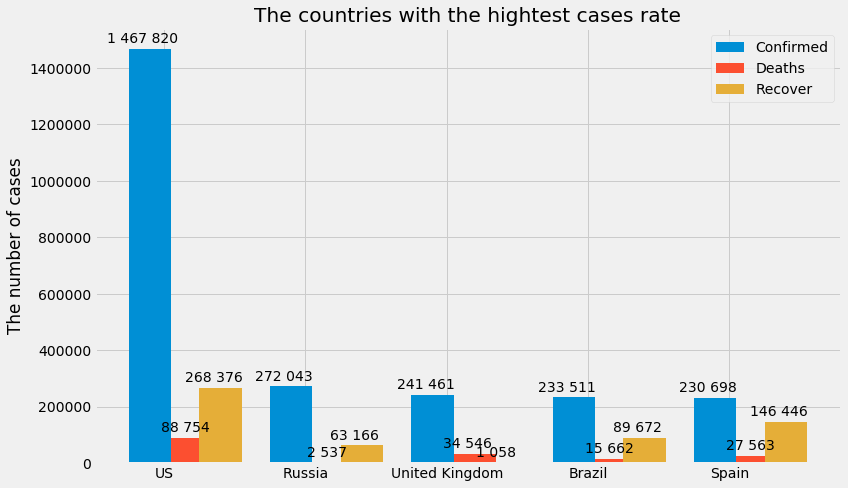

In [175]:
labels = all_country_last_day.index[0:5]
conf_means = all_country_last_day.iloc[0:5,0]
death_means = all_country_last_day.iloc[0:5,2]
recover_means = all_country_last_day.iloc[0:5,1]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(12,7))
rects1 = ax.bar(x - width/3, conf_means, width, label='Confirmed')
rects2 = ax.bar(x + 2*(width/3), death_means, width, label='Deaths')
rects3 = ax.bar(x + 4*(width/3), recover_means, width, label='Recover')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('The number of cases')
ax.set_title('The countries with the hightest cases rate')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:,}'.format(height).replace(',', ' '),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

In [101]:
all_country_last_day.loc['Russia',:]


conf         177160.000000
recover       23803.000000
death          1625.000000
mortality         0.009172
Name: Russia, dtype: float64

In [102]:
all_country_last_day[all_country_last_day['death']<=1625].head(10)

conf  recover  death  mortality
Country                                        
Russia        177160    23803   1625   0.009172
Saudi Arabia   33731     7798    219   0.006493
Portugal       26715     2258   1105   0.041363
Pakistan       24644     6464    585   0.023738
Chile          24581    11664    285   0.011594
Ireland        22385    17110   1403   0.062676
Singapore      20939     1712     20   0.000955
Belarus        20168     5067    116   0.005752
Qatar          18890     2286     12   0.000635
Israel         16381    10873    240   0.014651

In [44]:
all_country_last_day['mortality'] = all_country_last_day['death'] / all_country_last_day['conf']

In [132]:
higth_mortality = all_country_last_day.sort_values(by='mortality', ascending = False).head(11)

In [104]:
data_all_countries = pd.read_csv('covid19_all_merge.csv')

In [133]:
higth_mortality = higth_mortality.reset_index()

In [134]:
higth_mortality

Country    conf  recover  death  mortality
0        Nicaragua      16        7      5   0.312500
1       MS Zaandam       9        0      2   0.222222
2            Yemen      25        1      5   0.200000
3          Belgium   51420    12980   8415   0.163652
4           France  174918    55191  25990   0.148584
5   United Kingdom  207977      970  30689   0.147560
6            Italy  215858    96276  29958   0.138786
7      Netherlands   41973      147   5306   0.126415
8       Mauritania       8        6      1   0.125000
9          Comoros       8        0      1   0.125000
10          Sweden   24623     4971   3040   0.123462

In [138]:
#list_country = list(higth_mortality['Country'])
higth_mortality.drop(1,axis=0, inplace=True)
higth_mortality['Country'].str.strip()
#igth_mortality['Country'].str[:]

0          Nicaragua
2              Yemen
3            Belgium
4             France
5     United Kingdom
6              Italy
7        Netherlands
8         Mauritania
9            Comoros
10            Sweden
Name: Country, dtype: object

In [141]:
#data_all_countries.set_index('Country', inplace=True)
higth_mortality 

Country    conf  recover  death  mortality
0        Nicaragua      16        7      5   0.312500
2            Yemen      25        1      5   0.200000
3          Belgium   51420    12980   8415   0.163652
4           France  174918    55191  25990   0.148584
5   United Kingdom  207977      970  30689   0.147560
6            Italy  215858    96276  29958   0.138786
7      Netherlands   41973      147   5306   0.126415
8       Mauritania       8        6      1   0.125000
9          Comoros       8        0      1   0.125000
10          Sweden   24623     4971   3040   0.123462

In [154]:
higth_mortality.merge(data_all_countries,on='Country', how='left')

Country    conf  recover  death  mortality  Population  \
0       Nicaragua      16        7      5   0.312500   6,624,554   
1           Yemen      25        1      5   0.200000  29,825,964   
2         Belgium   51420    12980   8415   0.163652  11,589,623   
3          France  174918    55191  25990   0.148584  65,273,511   
4  United Kingdom  207977      970  30689   0.147560  67,886,011   
5           Italy  215858    96276  29958   0.138786  60,461,826   
6     Netherlands   41973      147   5306   0.126415  17,134,872   
7      Mauritania       8        6      1   0.125000   4,649,658   
8         Comoros       8        0      1   0.125000     869,601   
9          Sweden   24623     4971   3040   0.123462  10,099,265   

  Yearly_change Net_change Density_KM2m_x Land_Area_Km2  ...  \
0         1.21%     79,052             55       120,340  ...   
1         2.28%    664,042             56       527,970  ...   
2         0.44%     50,295            383        30,280  ...   
3         0.22%    143,783            119       547,557  ...   
4         0.53%    355,839            281       241,930  ...   
5        -0.15%    -88,249            206       294,140  ...   
6         0.22%     37,742            508        33,720  ...   
7         2.74%    123,962              5     1,030,700  ...   
8         2.20%     18,715            467         1,861  ...   
9         0.63%     62,886             25       410,340  ...   

  sex_male_to_female_55_64_years sex_male_to_female_over_65  \
0                           0.86                       0.81   
1                            NaN                        NaN   
2                           0.98                       0.76   
3                           0.93                       0.75   
4                           0.98                       0.81   
5                           0.94                       0.75   
6                           0.99                       0.82   
7                           0.82                       0.74   
8                            NaN                        NaN   
9                           1.01                       0.85   

  sex_male_to_female_total   latitude  longitude  age_0_to_14_years  \
0                     0.95  12.865416 -85.207229                NaN   
1                      NaN        NaN        NaN                NaN   
2                     0.97  50.503887   4.469936                NaN   
3                     0.96  46.227638   2.213749                NaN   
4                     0.99  55.378051  -3.435973                NaN   
5                     0.93  41.871940  12.567380                NaN   
6                     0.98  52.132633   5.291266                NaN   
7                     0.93  21.007890 -10.940835                NaN   
8                      NaN        NaN        NaN                NaN   
9                        1  60.128161  18.643501                NaN   

   age_15_to_64_years  age_over_65_years   Rank Rate_per_100000  
0                 NaN                NaN  109.0           24.91  
1                 NaN                NaN   69.0           54.48  
2                 NaN                NaN  113.0           24.22  
3                 NaN                NaN  152.0           14.10  
4                 NaN                NaN  119.0           23.01  
5                 NaN                NaN  175.0            8.15  
6                 NaN                NaN  149.0           14.56  
7                 NaN                NaN   18.0          138.44  
8                 NaN                NaN   19.0          128.67  
9                 NaN                NaN  144.0           15.57  

[10 rows x 92 columns]

In [962]:
higth_mortality = higth_mortality.rename({'Density_KM2m_x':'Deensity'}, inplace=True)

In [965]:
higth_mortality

In [150]:
data_all_countries[data_all_countries['Country']=='Sweden']

Country  Population Yearly_change Net_change Density_KM2m_x Land_Area_Km2  \
90  Sweden  10,099,265         0.63%     62,886             25       410,340   

   Migrants Fertility_rate_x Median_age_x Urban_pop_pct_x  ...  \
90   40,000              1.9           41             88%  ...   

   sex_male_to_female_55_64_years  sex_male_to_female_over_65  \
90                           1.01                        0.85   

    sex_male_to_female_total   latitude  longitude age_0_to_14_years  \
90                         1  60.128161  18.643501               NaN   

    age_15_to_64_years  age_over_65_years   Rank Rate_per_100000  
90                 NaN                NaN  144.0           15.57  

[1 rows x 88 columns]

In [153]:
data_all_countries['Country'].value_counts()

United Arab Emirates    1
Cambodia                1
Mozambique              1
Honduras                1
Angola                  1
                       ..
Italy                   1
Mali                    1
Romania                 1
New Caledonia           1
Israel                  1
Name: Country, Length: 235, dtype: int64

In [545]:
all_data[(all_data['Country']=='US') & (all_data['Date']==all_data['Date'].max())]

Country       Date     conf  ...  day_recover  death  day_death
19434      US 2020-05-04  1180375  ...       7028.0  68922     1240.0

[1 rows x 8 columns]

In [546]:
all_country_last_day.index[0:5]

Index(['US', 'Spain', 'Italy', 'United Kingdom', 'France'], dtype='object', name='Country')

In [547]:
all_country_last_day.iloc[0:5,0]

Country
US                1180375
Spain              218011
Italy              211938
United Kingdom     191832
France             169583
Name: conf, dtype: int64

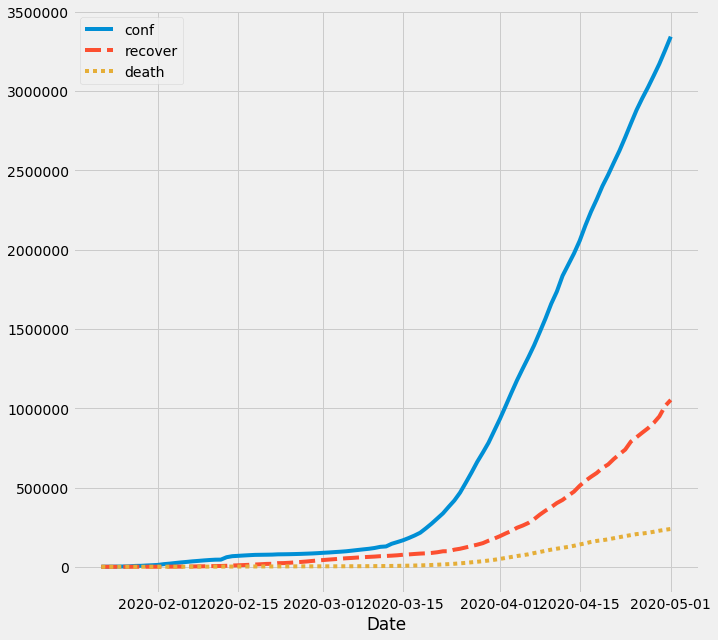

In [548]:
fig = plt.figure(figsize=(10,10))
sns.lineplot(data= data_days)

In [587]:
data_russia = all_data[all_data['Country']=='Russia'].copy()

In [676]:
data_russia['Day'] = data_russia['Date'].dt.day
data_russia['Month'] = data_russia['Date'].dt.month
data_russia['Dayofweek'] = data_russia['Date'].dt.dayofweek

In [723]:
X = data_russia[['Day','Month','Dayofweek']]
Y = data_russia['day_conf']


In [724]:
Y.fillna(0, inplace = True)

In [725]:
len(X)

104

In [726]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 

In [774]:
russia_model = XGBRegressor(n_estimators=100, learning_rate=0.05)
russia_model.fit(X_train, y_train, verbose=False)

[16:23:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [775]:
predictions = russia_model.predict(X_test)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

Mean Absolute Error: 206.61397176522476


In [776]:
r = predictions.max()
print ('%.2f'%r)  

9787.53


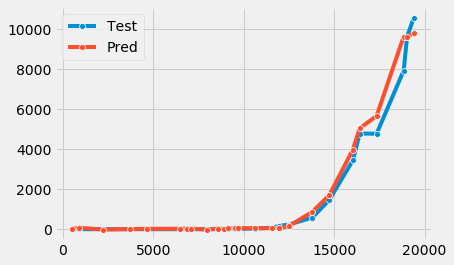

In [777]:
sns.lineplot(data=y_test, label='Test', marker='o')
sns.lineplot(x=y_test.index, y=predictions, label='Pred', marker='o')

In [643]:
y_test.index

Int64Index([ 8554, 11359, 13790,  1448,  7806, 15099,   700, 11733, 17156,
            10798, 14538, 16969, 16408,  4814, 11920,  2944,  5936,  4627,
             6310,  6871, 16034, 14725,  6684,  7058,  3879, 19400],
           dtype='int64')

In [791]:
new_time = pd.date_range('5/5/2020',periods=20)

In [785]:
X_new = pd.DataFrame({'Date':pd.date_range('5/5/2020',periods=20)}, index=np.arange(20))

In [786]:
X_new['Day'] = X_new['Date'].dt.day
X_new['Month'] = X_new['Date'].dt.month
X_new['Dayofweek'] = X_new['Date'].dt.dayofweek

In [787]:
X_date = X_new[['Day','Month','Dayofweek']]

In [788]:
predictions = russia_model.predict(X_date)
#print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_test)))

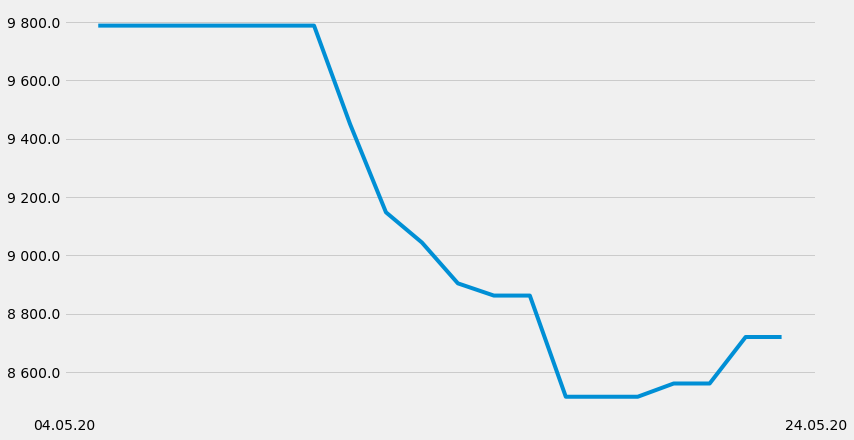

In [801]:
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(new_time, predictions)
month_locator = MonthLocator(interval=10)
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(DateFormatter('%d.%m.%y'))
formatter = FuncFormatter(lambda x, pos: '{:,}'.format(x).replace(',', ' '))
ax.yaxis.set_major_formatter(formatter)


In [783]:
predictions

array([9787.533, 9787.533, 9787.533, 9787.533, 9787.533, 9787.533,
       9787.533, 9450.699, 9147.656, 9044.058], dtype=float32)

In [797]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

(array([20.,  5.,  5.,  4.,  3.,  3.,  2.,  3.,  3.,  3.]),
 array([  1264. ,  29312.8,  57361.6,  85410.4, 113459.2, 141508. ,
        169556.8, 197605.6, 225654.4, 253703.2, 281752. ]),
 <a list of 10 Patch objects>)

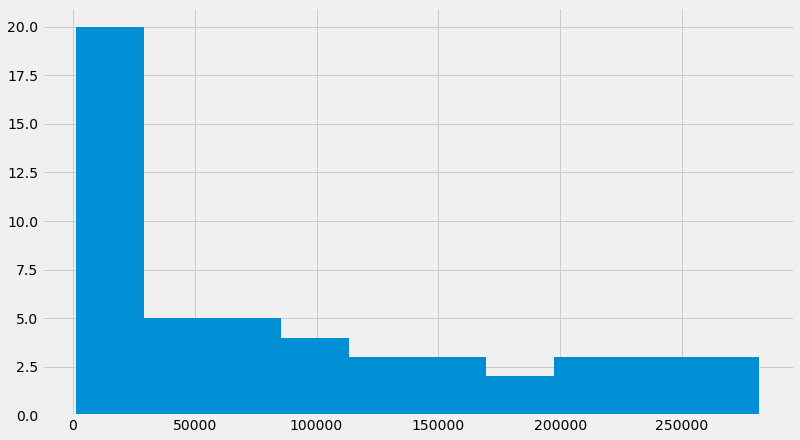

In [283]:
fig, ax = plt.subplots(figsize=(12,7))
ax.hist(index_date['conf'],bins=10)